# CatDogCNN

This notebook implements a Convolutional Neural Network (CNN) to classify images of cats and dogs. The model is trained using a dataset of images organized into separate directories for training and testing.

In [26]:
# Install missing packages
%pip install tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
# === MOUNT GOOGLE DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Set up dataset paths
DATASET_PATH = '/content/drive/My Drive/archive'  # Base path
DATASET_TRAIN = os.path.join(DATASET_PATH, 'train')  # Training endpoint
DATASET_TEST = os.path.join(DATASET_PATH, 'test')  # Testing endpoint
IMG_SIZE = (128, 128)  # Image size
BATCH_SIZE = 32
EPOCHS = 20

# Data generators
training_validation_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    validation_split=0.2
)

testing_data_gen = ImageDataGenerator(
    rescale=1./255
)

In [10]:
# Load training and validation data
train_ds = training_validation_data_gen.flow_from_directory(
    DATASET_TRAIN,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=42,
    shuffle=True
)

val_ds = training_validation_data_gen.flow_from_directory(
    DATASET_TRAIN,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42,
    shuffle=True
)

# Load test data
test_ds = testing_data_gen.flow_from_directory(
    DATASET_TEST,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=42,
    shuffle=True
)

Found 640 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [11]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,748,225 (10.48 MB)

 Trainable params: 2,748,225 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('CatDogCNN.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4906 - loss: 0.7109

20/20 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - accuracy: 0.4906 - loss: 0.7105 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4819 - loss: 0.6939

20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.4828 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4860 - loss: 0.6932

20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4864 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4855 - loss: 0.6924

20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4872 - loss: 0.6923 - val_accuracy: 0.5562 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5140 - loss: 0.6900 - val_accuracy: 0.5375 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5161 - loss: 0.6898 - val_accuracy: 0.5063 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5312 - loss: 0.6871 - val_accuracy: 0.5625 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5689 - loss: 0.6823

20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5688 - loss: 0.6824 - val_accuracy: 0.5750 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5685 - loss: 0.6850

20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5691 - loss: 0.6851 - val_accuracy: 0.5562 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5650 - loss: 0.6825 - val_accuracy: 0.5688 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6029 - loss: 0.6741

20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6023 - loss: 0.6744 - val_accuracy: 0.5813 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5896 - loss: 0.6875

20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5894 - loss: 0.6870 - val_accuracy: 0.5813 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5742 - loss: 0.6854 - val_accuracy: 0.5750 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5751 - loss: 0.6687 - val_accuracy: 0.5750 - val_loss: 0.7028 - learning_rate: 0.0010
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5969 - loss: 0.6728 - val_accuracy: 0.5188 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 16/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5474 - loss: 0.6810 - val_accuracy: 0.5188 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 17/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5781 - loss: 0.6747 - val_accuracy: 0.5688 - val_loss: 0.6842 - learning_rate: 0.0010
Epoch 18/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6155 - loss: 0.6474 - val_accuracy: 0.625

In [14]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 11s/step - accuracy: 0.5521 - loss: 0.6940
Test Accuracy: 0.5250


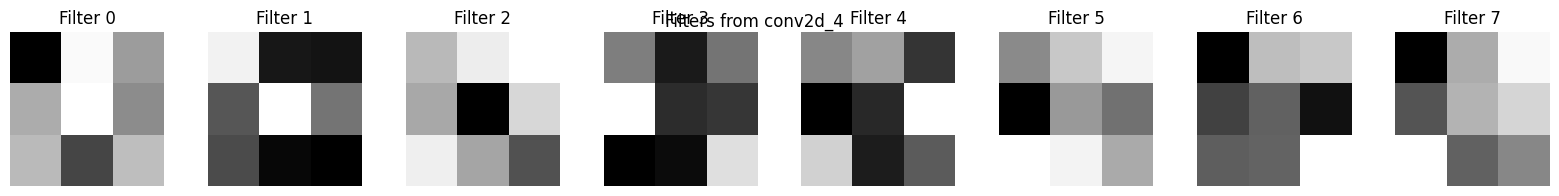

In [22]:
# Function to visualize filters
def visualize_filters(model, layer_name, num_filters=8):
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 2))
    for i in range(num_filters):
        if i < filters.shape[-1]:
            f = filters[:, :, :, i]
            f = np.mean(f, axis=2) if f.shape[2] == 3 else f
            axes[i].imshow(f, cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'Filter {i}')
    plt.suptitle(f'Filters from {layer_name}')
    plt.show()

# Visualize filters from the first convolutional layer
visualize_filters(model, 'conv2d_4', num_filters=8)

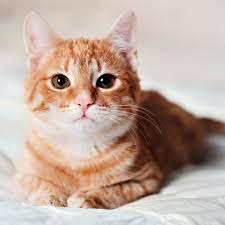

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: Cat


In [29]:
# Make a prediction on a new image
from tensorflow.keras.preprocessing import image

# Load the image
img_path = '/content/drive/My Drive/images.jpeg'  # Replace with the actual path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

display(Image(filename=img_path))
# Make the prediction
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("Prediction: Dog")
else:
    print("Prediction: Cat")